<a href="https://colab.research.google.com/github/sarimimran/Housing/blob/main/Zameen_propertyFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import re
import json
import math
import pprint
import requests
# import pandas_profiling
from scipy.stats import zscore
from collections import defaultdict
from urllib.request import urlopen, Request

import numpy as np
import pandas as pd
# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)
import missingno as msno
# system
import warnings
warnings.filterwarnings('ignore')
# garbage collector to keep RAM in check
import gc  
import matplotlib.gridspec as gridspec
from datetime import datetime


In [12]:
from google.colab import files 
uploaded=files.upload()

Saving zameen.xlsx to zameen.xlsx


In [13]:
data = pd.read_excel('zameen.xlsx')


In [14]:
data.head(10)

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,Year,Month,agency,agent
0,347795,8,https://www.zameen.com/Property/lahore_model_t...,House,220000000,Model Town,Lahore,Punjab,31.483869,74.325686,0,6 Kanal,For Sale,0,2019-07-17,2019,7,Real Biz International,Usama Khan
1,482892,48,https://www.zameen.com/Property/lahore_multan_...,House,40000000,Multan Road,Lahore,Punjab,31.431593,74.179980,5,1 Kanal,For Sale,5,2018-10-06,2018,10,Khan Estate,mohsinkhan and B
2,555962,75,https://www.zameen.com/Property/eden_eden_aven...,House,9500000,Eden,Lahore,Punjab,31.499348,74.416959,0,9 Marla,For Sale,3,2019-07-03,2019,7,Shahum Estate 2,"Babar Hameed, Raja Omar"
3,562843,3821,https://www.zameen.com/Property/gulberg_2_gulb...,House,125000000,Gulberg,Lahore,Punjab,31.522069,74.355512,7,1 Kanal,For Sale,8,2019-04-04,2019,4,NaN,NaN
4,686990,3522,https://www.zameen.com/Property/allama_iqbal_t...,House,21000000,Allama Iqbal Town,Lahore,Punjab,31.506483,74.286017,5,11 Marla,For Sale,6,2019-04-04,2019,4,NaN,NaN
5,785289,3102,https://www.zameen.com/Property/gulberg_paf_fa...,House,52000000,Gulberg,Lahore,Punjab,31.495909,74.350569,6,1 Kanal,For Sale,5,2019-06-02,2019,6,MATZ Services,Group Captain (R) Tajammul Baig
6,891543,4031,https://www.zameen.com/Property/military_accou...,House,16500000,Military Accounts Housing Society,Lahore,Punjab,31.421229,74.285560,7,8 Marla,For Sale,6,2019-07-03,2019,7,NaN,NaN
7,983065,3749,https://www.zameen.com/Property/eme_society_em...,House,32500000,EME Society,Lahore,Punjab,31.439978,74.209685,0,1 Kanal,For Sale,5,2019-07-03,2019,7,Sukhera Estate & Builders,Ahmed Sheraz Sukhera
8,983066,3745,https://www.zameen.com/Property/eme_society_em...,House,31500000,EME Society,Lahore,Punjab,31.437744,74.213490,0,1 Kanal,For Sale,6,2019-07-03,2019,7,Sukhera Estate & Builders,Ahmed Sheraz Sukhera
9,983075,3931,https://www.zameen.com/Property/izmir_town_izm...,House,40000000,Izmir Town,Lahore,Punjab,31.409106,74.181662,0,1.6 Kanal,For Sale,6,2019-07-03,2019,7,Sukhera Estate & Builders,Ahmed Sheraz Sukhera


In [16]:
z = np.abs(zscore(data['price']))
thresh = 3
outliers_indices = np.where(z > thresh)

In [17]:
print("Number of Outliers:", len(outliers_indices[0]), "with threshold:", thresh)
outliers_data = data.iloc[list(set(outliers_indices[0]))]

Number of Outliers: 3455 with threshold: 3


In [19]:
data.drop(labels=list(set(outliers_indices[0])), inplace=True)

In [21]:
print(data.shape)

(187938, 19)


In [22]:
outliers_data.shape

(3455, 19)

In [23]:
print(data.dtypes)

property_id               int64
location_id               int64
page_url                 object
property_type            object
price                     int64
location                 object
city                     object
province_name            object
latitude                float64
longitude               float64
baths                     int64
area                     object
purpose                  object
bedrooms                  int64
date_added       datetime64[ns]
Year                      int64
Month                     int64
agency                   object
agent                    object
dtype: object


In [24]:
def exp_to_float(num):
    s = str(num)
    if s.find("e+") >= 0:
        n, e = s.split('e+')
        n_e = float(n) * (10 ** int(e))
        return n_e
    else:
        return num

In [25]:
def index_to_date(indices):
    labels = []
    for i in range(len(indices.codes[0])):
        label = str(indices.levels[0][indices.codes[0][i]]) + '-' + str(indices.codes[1][i] + 1)
        labels.append(label)
    return labels

In [26]:
def rates_of_change(pivot_table):
    length = len(pivot_table)
    
    # For all Columns
    for column in list(pivot_table.columns):
        
        # Calculating Rates of Change
        rates = [0] * (length - 1)
        for i in range(length - 1):
            rates[i] = round((((pivot_table[column].values[i + 1] - pivot_table[column].values[i]) / pivot_table[column].values[i]) * 100), 2)
            #print(pivot_table.get_value(i,column)
                  
        # Adding Rates of Change to Pivot Table
        pivot_table.insert(pivot_table.columns.get_loc(column) + 1, ('rate_of_change_' + column), ([np.nan] + rates), allow_duplicates=True)
    
    cols = list(pivot_table.columns)
    num_cols = len(cols)
    
    # Plotting the Results
    fig, axs = plt.subplots(num_cols // 2, 2,figsize=(15, int(num_cols * 2.5)))
    x_ticks = index_to_date(pivot_table.index)
    plt.setp(axs, xticks = range(len(x_ticks)), xticklabels = x_ticks)
    
    for i in range(num_cols):
        axs[i // 2, i % 2].plot(pivot_table[str(cols[i])].values, label = str(cols[i]))
        axs[i // 2, i % 2].legend(loc = 0)
        axs[i // 2, i % 2].grid()
        axs[i // 2, i % 2].tick_params(labelrotation=45)
    
    return pivot_table

In [27]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
property_id,187938.0,1.573951e+07,2.210427e+06,128983.000000,1.513439e+07,1.677051e+07,1.715571e+07,1.769386e+07
location_id,187938.0,4.258544e+03,3.728452e+03,1.000000,1.053000e+03,3.241000e+03,7.185000e+03,1.424600e+04
price,187938.0,1.312844e+07,1.844519e+07,0.000000,8.000000e+04,7.000000e+06,1.700000e+07,1.185000e+08
latitude,187938.0,3.013342e+01,3.634216e+00,11.052446,2.498186e+01,3.146388e+01,3.355087e+01,7.318409e+01
longitude,187938.0,7.159686e+01,3.069989e+00,25.906027,6.716856e+01,7.307887e+01,7.422822e+01,8.016143e+01
baths,187938.0,2.835738e+00,2.406345e+00,0.000000,0.000000e+00,3.000000e+00,4.000000e+00,4.030000e+02
bedrooms,187938.0,3.132342e+00,1.912624e+00,0.000000,2.000000e+00,3.000000e+00,4.000000e+00,6.800000e+01
Year,187938.0,2.018935e+03,2.457176e-01,2018.000000,2.019000e+03,2.019000e+03,2.019000e+03,2.019000e+03
Month,187938.0,6.216970e+00,1.816569e+00,1.000000,6.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01


In [28]:
data['Year'] = pd.to_datetime(data['Year'], infer_datetime_format=True)


In [29]:
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)


In [30]:
data.reset_index(drop=True, inplace=True)

property_type                                                  Farm House  ...  rate_of_change_Upper Portion
Year                          Month                                        ...                              
1970-01-01 00:00:00.000002018 1970-01-01 00:00:00.000000008  5.480000e+07  ...                           NaN
                              1970-01-01 00:00:00.000000009  4.281200e+07  ...                        182.35
                              1970-01-01 00:00:00.000000010  5.383333e+07  ...                         -9.88
                              1970-01-01 00:00:00.000000011  3.764286e+07  ...                          9.19
                              1970-01-01 00:00:00.000000012  4.551350e+07  ...                        -44.08
1970-01-01 00:00:00.000002019 1970-01-01 00:00:00.000000001  2.898208e+07  ...                        -46.57
                              1970-01-01 00:00:00.000000002  4.743286e+07  ...                          8.37
                              1970-01-01 00:00:00.000000003  3.733320e+07  ...                         34.26
                              1970-01-01 00:00:00.000000004  3.027161e+07  ...                        -27.80
                              1970-01-01 00:00:00.000000005  2.872069e+07  ...                         31.99
                              1970-01-01 00:00:00.000000006  3.817927e+07  ...                         45.23
                              1970-01-01 00:00:00.000000007  2.332936e+07  ...                        -55.43
                              1970-01-01 00:00:00.000000008  6.450000e+07  ...                           NaN

[13 rows x 14 columns]

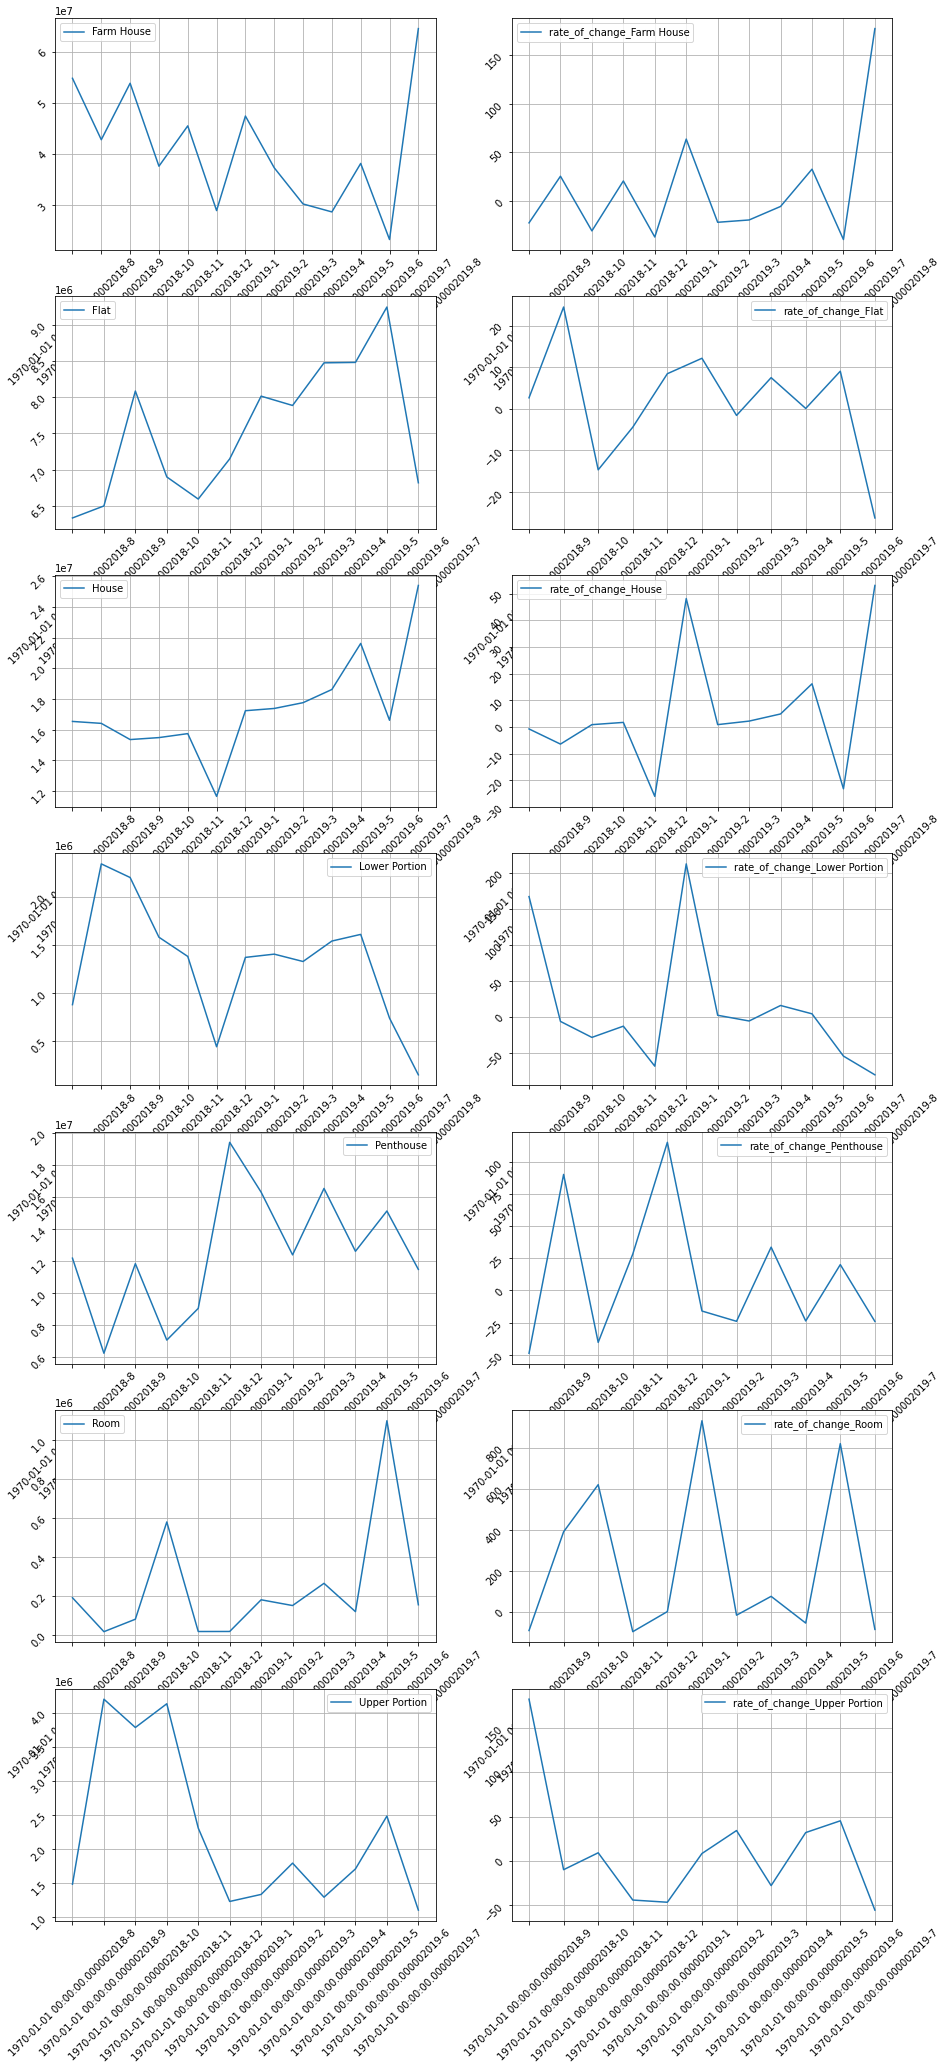

In [38]:
rate_of_change_wrt_type = pd.pivot_table(data, values = 'price', index = ['Year', 'Month'], columns=['property_type'], aggfunc = 'mean')
rates_of_change(rate_of_change_wrt_type)


property_type                                                  Farm House  ...  rate_of_change_Upper Portion
Year                          Month                                        ...                              
1970-01-01 00:00:00.000002018 1970-01-01 00:00:00.000000008  5.480000e+07  ...                           NaN
                              1970-01-01 00:00:00.000000009  4.281200e+07  ...                        182.35
                              1970-01-01 00:00:00.000000010  5.383333e+07  ...                         -9.88
                              1970-01-01 00:00:00.000000011  3.764286e+07  ...                          9.19
                              1970-01-01 00:00:00.000000012  4.551350e+07  ...                        -44.08
1970-01-01 00:00:00.000002019 1970-01-01 00:00:00.000000001  2.898208e+07  ...                        -46.57
                              1970-01-01 00:00:00.000000002  4.743286e+07  ...                          8.37
                              1970-01-01 00:00:00.000000003  3.733320e+07  ...                         34.26
                              1970-01-01 00:00:00.000000004  3.027161e+07  ...                        -27.80
                              1970-01-01 00:00:00.000000005  2.872069e+07  ...                         31.99
                              1970-01-01 00:00:00.000000006  3.817927e+07  ...                         45.23
                              1970-01-01 00:00:00.000000007  2.332936e+07  ...                        -55.43
                              1970-01-01 00:00:00.000000008  6.450000e+07  ...                           NaN

[13 rows x 14 columns]

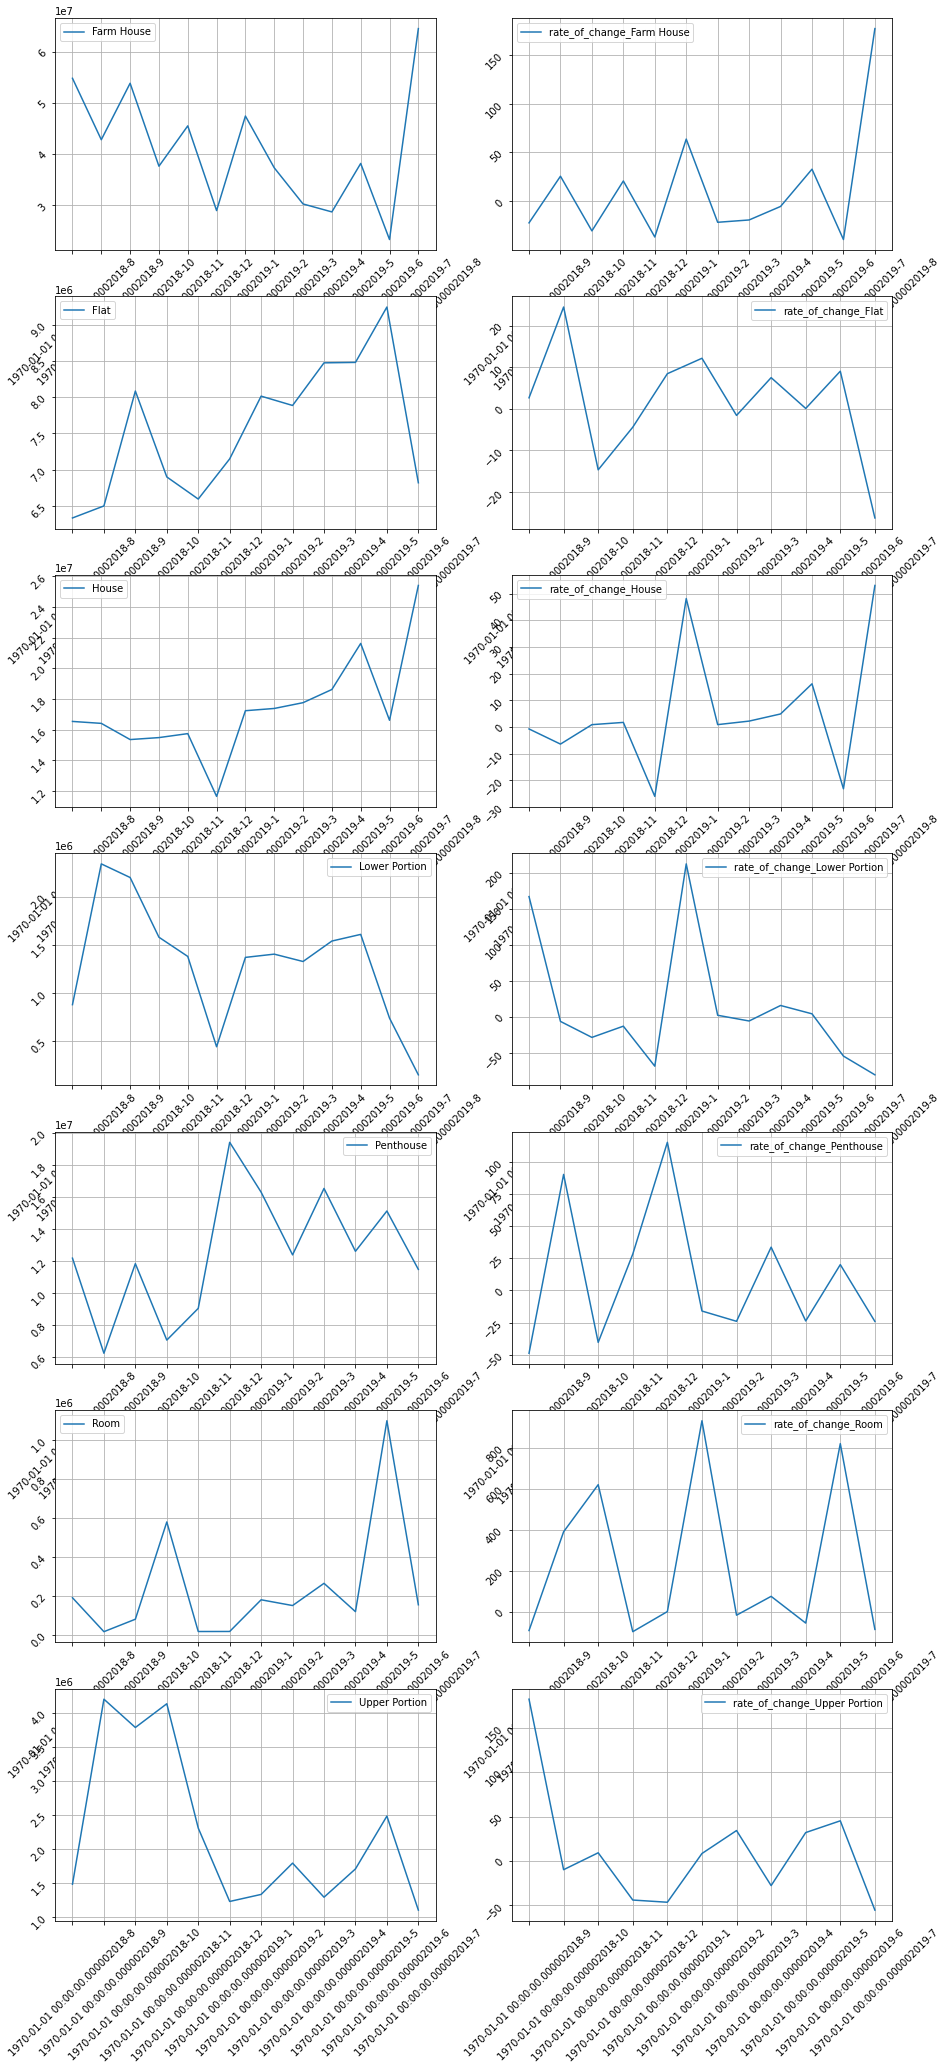

In [47]:
rate_of_change_wrt_type = pd.pivot_table(data, values = 'price', index = ['Year', 'Month'], columns=['property_type'], aggfunc = 'mean')
rates_of_change(rate_of_change_wrt_type)

city                                                           Faisalabad  ...  rate_of_change_Rawalpindi
Year                          Month                                        ...                           
1970-01-01 00:00:00.000002018 1970-01-01 00:00:00.000000008  8.830305e+06  ...                        NaN
                              1970-01-01 00:00:00.000000009  9.109872e+06  ...                       7.67
                              1970-01-01 00:00:00.000000010  7.648912e+06  ...                      -5.43
                              1970-01-01 00:00:00.000000011  7.520558e+06  ...                     -14.69
                              1970-01-01 00:00:00.000000012  6.772297e+06  ...                       9.34
1970-01-01 00:00:00.000002019 1970-01-01 00:00:00.000000001  5.960707e+06  ...                     -66.54
                              1970-01-01 00:00:00.000000002  5.427381e+06  ...                     154.51
                              1970-01-01 00:00:00.000000003  6.491346e+06  ...                      36.68
                              1970-01-01 00:00:00.000000004  6.628124e+06  ...                      15.33
                              1970-01-01 00:00:00.000000005  6.363861e+06  ...                     -14.92
                              1970-01-01 00:00:00.000000006  6.262864e+06  ...                     -15.70
                              1970-01-01 00:00:00.000000007  8.618305e+06  ...                     -23.62
                              1970-01-01 00:00:00.000000008           NaN  ...                        NaN

[13 rows x 10 columns]

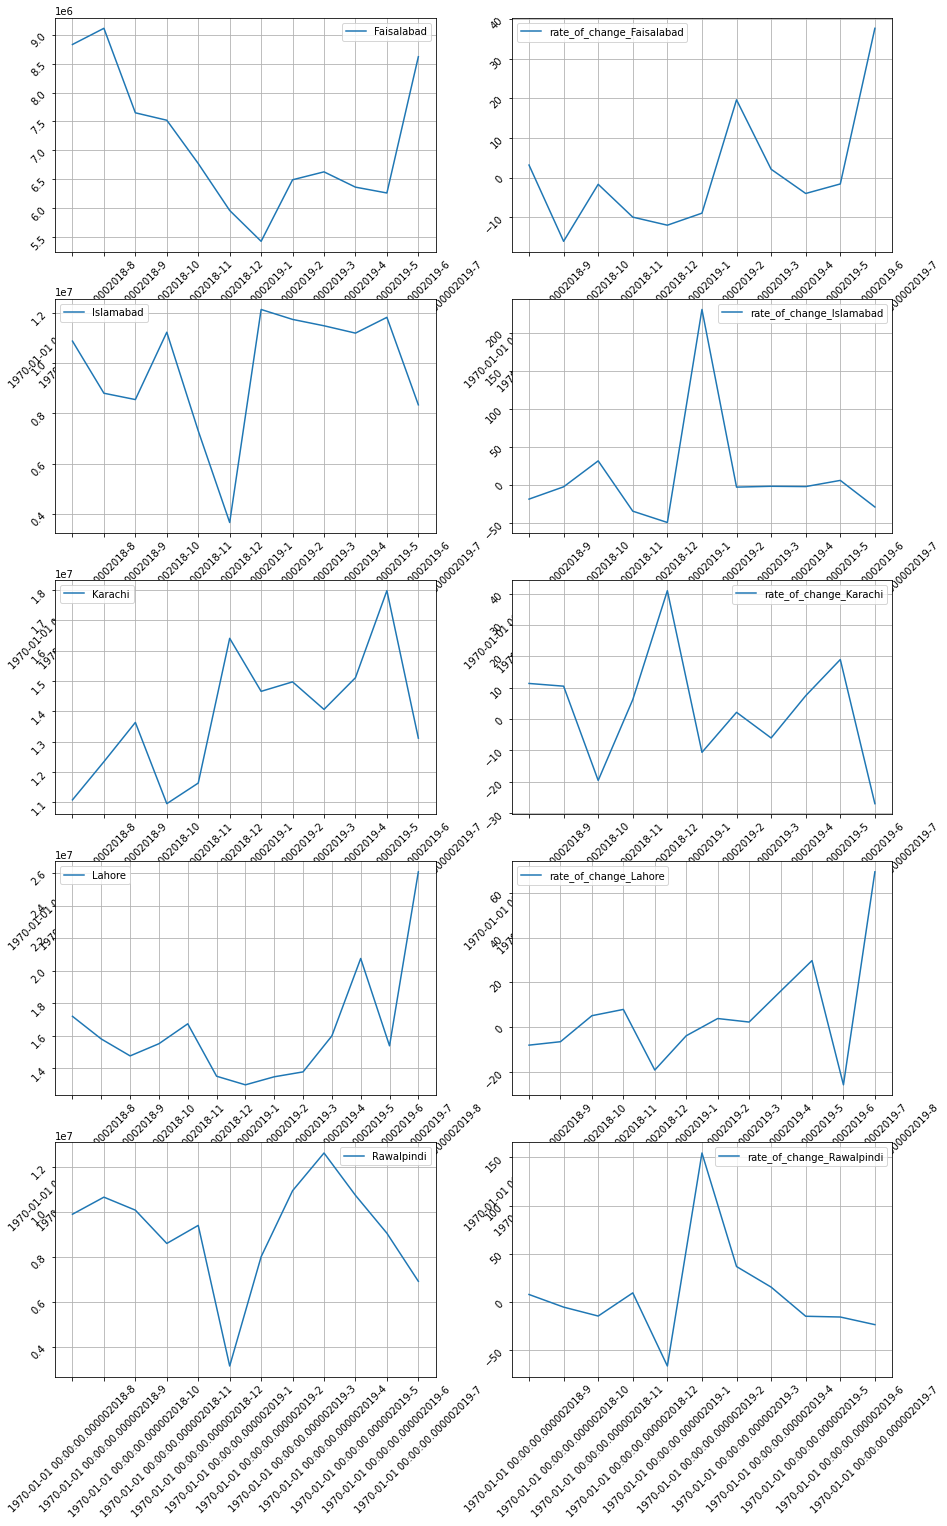

In [49]:
rate_of_change_wrt_city = pd.pivot_table(data, values = 'price', index = ['Year', 'Month'], columns=['city'], aggfunc = 'mean')
rates_of_change(rate_of_change_wrt_city)